# Data Transformation From pdf to json

The goal here is to transform the pdf into a json format to be exploitable by the LLM
The Json will be like this : 

{
    
        Instruction : a string witch say what want the user

        
        Input : the equivalence of a sheet with those info : 
            - The goal distance(None, distance[5km,1miles, etc...])   
            - The goal time (None, time[30minutes, below 1hours, etc...])
            - The level (None, level[beginner, advanced, ect...])  
            - The Number of weeks before the run, or of training (None, weeks[10, 20, 1years, etc...])  
            - The Number of training by weeks (None, 1, 2, 4, ect...) 
            - The age (None, 40, 50, etc...)


        Ouput : The equivalence of a 2D sheet with 8 Collums :
            - The week (first week, second, ect...)  
            - Monday
            - Tuesday
            - Wednesday
            - ....
            - Sunday        

}

None means that there are no info about it (for example None for the age means everyone can do it)

# Data Transformation For Training

In [13]:
import json
import os
import sys
import requests
import torch
import torch.nn as nn
import tiktoken
from torch.utils.data import Dataset, DataLoader
from functools import partial
from tqdm import tqdm
import time
import re

# Load the NEW augmented training dataset
print("Loading augmented training dataset...")
with open("Data/running_week_training_dataset_final.json", "r", encoding="utf-8") as file:
    dataset_full = json.load(file)

# Extract training data and metadata
training_data = dataset_full.get("training_data", [])
metadata = dataset_full.get("metadata", {})
stats = metadata.get("statistics", {})

print(f"\n{'='*80}")
print("AUGMENTED DATASET STATISTICS")
print(f"{'='*80}")
print(f"Total training examples: {len(training_data)}")
print(f"Dataset generated with {metadata.get('augmentation_factor', 'N/A')}x augmentation")
print(f"Original weeks: {metadata.get('total_weeks', 'N/A')}")

print(f"\nDistribution by level:")
for level, count in stats.get('by_level', {}).items():
    percentage = (count / max(len(training_data), 1)) * 100
    print(f"  {level}: {count} ({percentage:.1f}%)")

print(f"\nDistribution by goal:")
for goal, count in stats.get('by_goal', {}).items():
    percentage = (count / max(len(training_data), 1)) * 100
    print(f"  {goal}: {count} ({percentage:.1f}%)")

print(f"\nDistribution by training days:")
for days, count in stats.get('by_training_days', {}).items():
    percentage = (count / max(len(training_data), 1)) * 100
    print(f"  {days}d: {count} ({percentage:.1f}%)")

print(f"\n{'='*80}\n")

# Data quality filter: keep weeks with at least 2 non-rest days and 7 lines
day_pattern = re.compile(r"^(lundi|mardi|mercredi|jeudi|vendredi|samedi|dimanche)\s*:", re.IGNORECASE)
rest_pattern = re.compile(r"\b(rest|day off)\b", re.IGNORECASE)

MIN_NON_REST_DAYS = 2
MIN_NON_REST_CHARS = 12
RICHNESS_BOOST_THRESHOLD = 18
DIVERSITY_BOOST_THRESHOLD = 2

def richness_score(output_text: str) -> float:
    lines = [l.strip() for l in output_text.split("\n") if l.strip()]
    non_rest_lines = [l for l in lines[:7] if not rest_pattern.search(l)]
    if not non_rest_lines:
        return 0.0
    return sum(len(l) for l in non_rest_lines) / len(non_rest_lines)

def diversity_score(output_text: str) -> int:
    lines = [l.strip() for l in output_text.split("\n") if l.strip()]
    non_rest_lines = [l for l in lines[:7] if not rest_pattern.search(l)]
    activities = set()
    for line in non_rest_lines:
        lower = line.lower()
        if "long run" in lower:
            activities.add("long")
        elif "interval" in lower:
            activities.add("interval")
        elif "tempo" in lower:
            activities.add("tempo")
        elif "marathon pace" in lower:
            activities.add("pace")
        elif "easy run" in lower:
            activities.add("easy")
        elif "recovery" in lower:
            activities.add("recovery")
        elif "run" in lower:
            activities.add("run")
    return len(activities)

def is_good_example(output_text: str) -> bool:
    if not output_text:
        return False
    lines = [l.strip() for l in output_text.split("\n") if l.strip()]
    if len(lines) < 7:
        return False
    if sum(1 for l in lines[:7] if day_pattern.search(l)) < 5:
        return False
    non_rest = [l for l in lines[:7] if not rest_pattern.search(l)]
    if len(non_rest) < MIN_NON_REST_DAYS:
        return False
    avg_len = sum(len(l) for l in non_rest) / len(non_rest)
    return avg_len >= MIN_NON_REST_CHARS

filtered_training_data = [e for e in training_data if is_good_example(e.get("output", ""))]
print(f"Filtered examples kept: {len(filtered_training_data)} / {len(training_data)}")

# Boost richer and more diverse weeks to penalize repetition bias
boosted_training_data = []
for e in filtered_training_data:
    boosted_training_data.append(e)
    if richness_score(e.get("output", "")) >= RICHNESS_BOOST_THRESHOLD:
        boosted_training_data.append(e)
    if diversity_score(e.get("output", "")) >= DIVERSITY_BOOST_THRESHOLD:
        boosted_training_data.append(e)
print(f"Boosted examples: {len(boosted_training_data)} / {len(filtered_training_data)}")

# Keep only essential metadata to avoid overfitting on workout_types/noisy fields
ESSENTIAL_METADATA_KEYS = {
    "program",
    "week",
    "total_weeks",
    "training_days",
    "goal",
    "level",
}

def prune_metadata(meta: dict) -> dict:
    if not isinstance(meta, dict):
        return {}
    return {k: meta.get(k) for k in ESSENTIAL_METADATA_KEYS if k in meta}

# Transform to instruction format compatible with our model
instruction_data = []
for entry in boosted_training_data:
    instruction_data.append({
        "instruction": entry.get("instruction", ""),
        "input": entry.get("input", ""),
        "output": entry.get("output", ""),
        "metadata": prune_metadata(entry.get("metadata", {}))
    })

print(f"Total instruction examples prepared: {len(instruction_data)}")
if len(instruction_data) > 0:
    # pick a better example with more non-rest days
    best_entry = max(instruction_data, key=lambda e: sum(1 for l in e['output'].split('\n') if l.strip() and not rest_pattern.search(l)))
    print(f"\nExample entry (filtered, week-level format):")
    print(json.dumps(best_entry, indent=2, ensure_ascii=False))

print("M")

Loading augmented training dataset...

AUGMENTED DATASET STATISTICS
Total training examples: 2036
Dataset generated with 2x augmentation
Original weeks: N/A

Distribution by level:
  general: 1288 (63.3%)
  maintenance: 40 (2.0%)
  beginner: 284 (13.9%)
  advanced: 320 (15.7%)
  intermediate: 104 (5.1%)

Distribution by goal:
  marathon: 1432 (70.3%)
  general fitness: 52 (2.6%)
  16.1km: 4 (0.2%)
  halfmarathon: 388 (19.1%)
  5km: 100 (4.9%)
  10km: 48 (2.4%)
  1.6km: 12 (0.6%)

Distribution by training days:
  4d: 412 (20.2%)
  5d: 1000 (49.1%)
  6d: 580 (28.5%)
  7d: 40 (2.0%)
  3d: 4 (0.2%)


Filtered examples kept: 2036 / 2036
Boosted examples: 5404 / 2036
Total instruction examples prepared: 5404

Example entry (filtered, week-level format):
{
  "instruction": "Generate a complete week (2) of a 19-week marathon running program. Training level: general, 6 training days per week. Format attendu: 7 lignes, une par jour, de Lundi à Dimanche, au format 'Jour: Activité'.",
  "input": "

# Format Input & Load Tokenizer

In [2]:
def format_input(entry):
    """Format instruction data in Alpaca-style prompt format"""
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    return instruction_text + input_text

# Load tokenizer
tokenizer = tiktoken.get_encoding("gpt2")

# Pick a more informative example for preview
best_entry = max(
    instruction_data,
    key=lambda e: sum(1 for l in e["output"].split("\n") if l.strip() and "rest" not in l.lower()),
)

# Test formatting
model_input = format_input(best_entry)
desired_response = f"\n\n### Response:\n{best_entry['output']}"

print("Example formatted prompt (first 1000 characters):")
print((model_input + desired_response)[:1000])
print(f"\nTotal length: {len(model_input + desired_response)} characters")

Example formatted prompt (first 1000 characters):
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Generate a complete week (2) of a 19-week marathon running program. Training level: general, 6 training days per week. Format attendu: 7 lignes, une par jour, de Lundi à Dimanche, au format 'Jour: Activité'.

### Input:
Objectif: marathon; Niveau: general; Semaines: 19; Séances/sem: 6; Temps objectif: 3h30m.

### Response:
Lundi: 8.0km Run
Mardi: 5.0km Run
Mercredi: 5 km
Jeudi: 5.0km Run
Vendredi: 8.0km Run
Samedi: Rest
Dimanche: 18.0km Long Run

Total length: 573 characters


# Split Data into Train/Val/Test

In [3]:
import random

# Split dataset with random shuffle to reduce ordering bias
seed = 42
random.seed(seed)
shuffled = instruction_data.copy()
random.shuffle(shuffled)

train_portion = int(len(shuffled) * 0.7)   # 70% for training
val_portion = int(len(shuffled) * 0.15)    # 15% for validation
test_portion = len(shuffled) - train_portion - val_portion  # 15% for testing

train_data = shuffled[:train_portion]
val_data = shuffled[train_portion:train_portion + val_portion]
test_data = shuffled[train_portion + val_portion:]

print(f"Total dataset size: {len(shuffled)}")
print(f"Training set length: {len(train_data)} ({len(train_data)/len(shuffled)*100:.1f}%)")
print(f"Validation set length: {len(val_data)} ({len(val_data)/len(shuffled)*100:.1f}%)")
print(f"Test set length: {len(test_data)} ({len(test_data)/len(shuffled)*100:.1f}%)")
print(f"Shuffle seed: {seed}")

Total dataset size: 5396
Training set length: 3777 (70.0%)
Validation set length: 809 (15.0%)
Test set length: 810 (15.0%)
Shuffle seed: 42


# Create Dataset and DataLoaders

In [4]:
class InstructionDataset(Dataset):
    """Dataset for instruction-following training"""
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(tokenizer.encode(full_text))
    
    def __getitem__(self, index):
        return self.encoded_texts[index]
    
    def __len__(self):
        return len(self.data)


def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    """Custom collate function for batching sequences"""
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)
    
    inputs_lst, targets_lst = [], []
    
    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        
        # Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index
        
        # Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]
        
        inputs_lst.append(inputs)
        targets_lst.append(targets)
    
    # Convert to tensors and transfer to device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    
    return inputs_tensor, targets_tensor


# Setup device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

print(f"Device: {device}")

# Create custom collate function with device
customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

# Create datasets
train_dataset = InstructionDataset(train_data, tokenizer)
val_dataset = InstructionDataset(val_data, tokenizer)
test_dataset = InstructionDataset(test_data, tokenizer)

# Create data loaders
batch_size = 2
num_workers = 0

torch.manual_seed(123)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

print("\nTrain loader batches:")
for i, (inputs, targets) in enumerate(train_loader):
    if i < 2:
        print(f"Batch {i}: inputs shape {inputs.shape}, targets shape {targets.shape}")
    else:
        break

Device: cpu

Train loader batches:
Batch 0: inputs shape torch.Size([2, 180]), targets shape torch.Size([2, 180])
Batch 1: inputs shape torch.Size([2, 185]), targets shape torch.Size([2, 185])


# Load Pretrained GPT-2 Model
Note: This section loads a GPT-2 small model (124M) for faster training. You can modify the model size in the configuration below.

In [5]:
# For this demonstration, we'll create a simple GPT-like model
# since we need a minimal model for training on CPU/limited GPU

class SimpleGPT(nn.Module):
    """Simplified GPT model for instruction finetuning"""
    def __init__(self, vocab_size=50257, embedding_dim=256, n_layers=4, n_heads=4, context_length=1024):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.pos_embedding = nn.Embedding(context_length, embedding_dim)
        
        # Transformer layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=n_heads,
            dim_feedforward=512,
            batch_first=True,
            dropout=0.1
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        # Output layer
        self.output_layer = nn.Linear(embedding_dim, vocab_size)
    
    def forward(self, input_ids):
        seq_len = input_ids.size(1)
        pos_ids = torch.arange(seq_len, device=input_ids.device).unsqueeze(0)
        
        token_emb = self.token_embedding(input_ids)
        pos_emb = self.pos_embedding(pos_ids)
        x = token_emb + pos_emb
        
        x = self.transformer(x)
        logits = self.output_layer(x)
        return logits

# Initialize model
model = SimpleGPT(
    vocab_size=50257,
    embedding_dim=256,
    n_layers=4,
    n_heads=4,
    context_length=1024
)

print(f"Model architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

Model architecture:
SimpleGPT(
  (token_embedding): Embedding(50257, 256)
  (pos_embedding): Embedding(1024, 256)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=256, out_features=50257, bias=True)
)

Total parameters: 28,152,401


# Training Setup and Loss Functions

In [6]:
# Lower weight for Rest tokens to reduce overfitting
REST_TOKEN_IDS = set()
for token in [" Rest", " rest", "Rest", "rest"]:
    REST_TOKEN_IDS.update(tokenizer.encode(token))
REST_TOKEN_WEIGHT = 0.3
VOCAB_SIZE = 50257
TOKEN_WEIGHTS = torch.ones(VOCAB_SIZE)
for tid in REST_TOKEN_IDS:
    if 0 <= tid < VOCAB_SIZE:
        TOKEN_WEIGHTS[tid] = REST_TOKEN_WEIGHT

def calc_loss_batch(input_batch, target_batch, model, device):
    """Calculate loss for a batch"""
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    
    logits = model(input_batch)
    
    # Reshape for loss calculation
    logits_flat = logits.view(-1, logits.size(-1))
    targets_flat = target_batch.view(-1)
    
    # Use CrossEntropyLoss with ignore_index and lower weight for Rest tokens
    loss_fn = nn.CrossEntropyLoss(ignore_index=-100, weight=TOKEN_WEIGHTS.to(device))
    loss = loss_fn(logits_flat, targets_flat)
    
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    """Calculate average loss over data loader"""
    total_loss = 0.0
    total_batches = 0
    
    with torch.no_grad():
        for batch_idx, (input_batch, target_batch) in enumerate(data_loader):
            if num_batches is not None and batch_idx >= num_batches:
                break
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
            total_batches += 1
    
    return total_loss / total_batches if total_batches > 0 else float('inf')


# Move model to device
model.to(device)

# Calculate initial loss
print("Calculating initial losses...")
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print(f"Initial Training loss: {train_loss:.4f}")
print(f"Initial Validation loss: {val_loss:.4f}")

Calculating initial losses...
Initial Training loss: 10.9907
Initial Validation loss: 10.9904


# Train the Model

In [7]:
def train_model(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq):
    """Train the model with validation and week-level generation"""
    train_losses, val_losses = [], []
    week_coherence_scores = []
    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        train_batches = 0
        
        # Training loop
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for input_batch, target_batch in progress_bar:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            train_batches += 1
            progress_bar.set_postfix({'loss': loss.item()})
        
        avg_train_loss = total_train_loss / train_batches
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        avg_val_loss = calc_loss_loader(val_loader, model, device)
        val_losses.append(avg_val_loss)
        
        print(f"\nEpoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}")
        
        # Week generation evaluation (every 2 epochs or at end)
        if (epoch + 1) % eval_freq == 0 or epoch == num_epochs - 1:
            print(f"\n--- Week Generation Evaluation (Epoch {epoch+1}) ---")
            coherence = evaluate_week_generation(model, test_data[:5], tokenizer, device)
            week_coherence_scores.append(coherence)
            print(f"Week Coherence Score: {coherence:.1f}%\n")
    
    return train_losses, val_losses, week_coherence_scores


def evaluate_week_generation(model, test_samples, tokenizer, device, max_tokens=300):
    """
    Evaluate week generation by checking:
    1. Does it generate 7+ lines (roughly one per day)?
    2. Does it contain recognizable training terms?
    3. Does it have varied activities (not all "Rest")?
    """
    model.eval()
    coherence_scores = []
    
    training_keywords = ['rest', 'run', 'easy', 'tempo', 'interval', 'cross', 'long', 'mile', 'km', 'repeats', 'track', 'warm', 'cool']
    
    with torch.no_grad():
        for entry in test_samples:
            # Generate prediction using the instruction format
            prompt = (
                f"Below is an instruction that describes a task. "
                f"Write a response that appropriately completes the request."
                f"\n\n### Instruction:\n{entry['instruction']}"
            )
            if entry.get('input'):
                prompt += f"\n\n### Input:\n{entry['input']}"
            prompt += f"\n\n### Response:\n"
            
            input_ids = tokenizer.encode(prompt)
            input_ids = torch.tensor([input_ids[:1024]], dtype=torch.long).to(device)
            
            # Generate with greedy decoding
            output_ids = input_ids.clone()
            for _ in range(max_tokens):
                logits = model(output_ids)
                next_token_logits = logits[0, -1, :]
                next_token = torch.argmax(next_token_logits, dim=-1)
                output_ids = torch.cat([output_ids, next_token.view(1, 1)], dim=1)
                
                if next_token.item() == 50256:  # endoftext
                    break
            
            # Decode and evaluate
            generated_text = tokenizer.decode(output_ids[0].cpu().numpy())
            generated = generated_text.split("### Response:\n")[-1].strip()
            
            # Scoring criteria
            score = 0
            
            # 1. Check number of lines (should have ~7 for a week)
            lines = [l for l in generated.split('\n') if l.strip()]
            if 5 <= len(lines) <= 9:
                score += 30
            elif len(lines) >= 3:
                score += 15
            
            # 2. Check for training keywords
            text_lower = generated.lower()
            keyword_count = sum(1 for kw in training_keywords if kw in text_lower)
            score += min(40, keyword_count * 5)  # Max 40 points
            
            # 3. Check for variety (not all same activity)
            if text_lower.count('rest') < len(lines) * 0.8:  # Not all rest
                score += 30
            
            coherence_scores.append(min(100, score))
    
    return sum(coherence_scores) / len(coherence_scores) if coherence_scores else 0


# Training parameters - optimized for 1716 augmented examples
num_epochs = 8  # Increased from 3 to better leverage more data
learning_rate = 0.0001  # More conservative learning rate for stability
batch_size = 8  # Increased for better gradient estimates with more data

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1)

print("="*80)
print("TRAINING AVEC LE NOUVEAU DATASET AUGMENTÉ")
print("="*80)
print(f"Epochs: {num_epochs}")
print(f"Learning Rate: {learning_rate}")
print(f"Batch Size: {batch_size}")
print(f"Total Training Examples: {len(train_data)}")
print(f"Training Batches per Epoch: {len(train_loader)}")
print("="*80 + "\n")

print("Starting training with week generation evaluation...")
start_time = time.time()

train_losses, val_losses, week_coherence_scores = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=2  # Evaluate every 2 epochs
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"\n{'='*80}")
print(f"Training completed in {execution_time_minutes:.2f} minutes.")
if len(week_coherence_scores) > 0:
    print(f"Final week coherence score: {week_coherence_scores[-1]:.1f}%")
print(f"{'='*80}")


TRAINING AVEC LE NOUVEAU DATASET AUGMENTÉ
Epochs: 8
Learning Rate: 0.0001
Batch Size: 8
Total Training Examples: 3777
Training Batches per Epoch: 1888

Starting training with week generation evaluation...


Epoch 1/8: 100%|██████████| 1888/1888 [08:42<00:00,  3.61it/s, loss=0.225]



Epoch 1: Train Loss=1.0807, Val Loss=0.2345


Epoch 2/8: 100%|██████████| 1888/1888 [08:22<00:00,  3.75it/s, loss=0.0776]



Epoch 2: Train Loss=0.1739, Val Loss=0.0789

--- Week Generation Evaluation (Epoch 2) ---
Week Coherence Score: 71.0%



Epoch 3/8: 100%|██████████| 1888/1888 [08:50<00:00,  3.56it/s, loss=0.00943]



Epoch 3: Train Loss=0.0519, Val Loss=0.0183


Epoch 4/8: 100%|██████████| 1888/1888 [08:30<00:00,  3.70it/s, loss=0.0152]  



Epoch 4: Train Loss=0.0171, Val Loss=0.0069

--- Week Generation Evaluation (Epoch 4) ---
Week Coherence Score: 65.0%



Epoch 5/8: 100%|██████████| 1888/1888 [08:23<00:00,  3.75it/s, loss=0.000719]



Epoch 5: Train Loss=0.0081, Val Loss=0.0032


Epoch 6/8: 100%|██████████| 1888/1888 [07:21<00:00,  4.27it/s, loss=0.00619] 



Epoch 6: Train Loss=0.0044, Val Loss=0.0021

--- Week Generation Evaluation (Epoch 6) ---
Week Coherence Score: 68.0%



Epoch 7/8: 100%|██████████| 1888/1888 [07:32<00:00,  4.17it/s, loss=0.000743]



Epoch 7: Train Loss=0.0031, Val Loss=0.0019


Epoch 8/8: 100%|██████████| 1888/1888 [08:22<00:00,  3.76it/s, loss=0.000909]



Epoch 8: Train Loss=0.0022, Val Loss=0.0013

--- Week Generation Evaluation (Epoch 8) ---
Week Coherence Score: 74.0%


Training completed in 69.79 minutes.
Final week coherence score: 74.0%


# Visualize Training Results

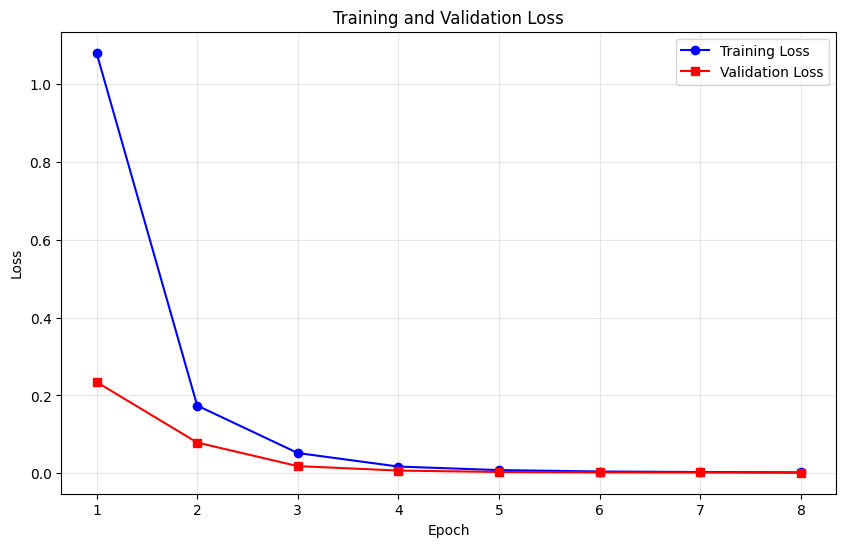


Final Training Loss: 0.0022
Final Validation Loss: 0.0013


In [10]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
epochs_range = range(1, num_epochs + 1)
plt.plot(epochs_range, train_losses, 'b-o', label='Training Loss')
plt.plot(epochs_range, val_losses, 'r-s', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nFinal Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")

In [11]:
import re

print("\n" + "="*80)
print("GÉNÉRATION D'UNE SEMAINE COMPLÈTE D'ENTRAÎNEMENT (TOP-K SAMPLING)")
print("="*80 + "\n")

def apply_repetition_penalty(logits, generated_ids, penalty=1.2):
    if penalty == 1.0 or generated_ids.numel() == 0:
        return logits
    unique_ids = torch.unique(generated_ids)
    logits[unique_ids] = logits[unique_ids] / penalty
    return logits

def generate_with_sampling(model, prompt_ids, tokenizer, device, max_tokens=200, 
                          top_k=50, temperature=0.7, stop_token=50256, repetition_penalty=1.2):
    """
    Generate text using top-k sampling with repetition penalty
    """
    model.eval()
    output_ids = prompt_ids.clone()
    
    with torch.no_grad():
        for _ in range(max_tokens):
            logits = model(output_ids)
            next_token_logits = logits[0, -1, :] / temperature
            next_token_logits = apply_repetition_penalty(next_token_logits, output_ids[0], penalty=repetition_penalty)
            
            top_k_logits, top_k_indices = torch.topk(next_token_logits, top_k)
            top_k_probs = torch.softmax(top_k_logits, dim=-1)
            sampled_idx = torch.multinomial(top_k_probs, 1)
            next_token = top_k_indices[sampled_idx]
            output_ids = torch.cat([output_ids, next_token.view(1, 1)], dim=1)
            
            if next_token.item() == stop_token:
                break
    
    return output_ids


def build_prompt(instruction_text, input_text):
    prompt_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{instruction_text}"
    )
    if input_text:
        prompt_text += f"\n\n### Input:\n{input_text}"
    prompt_text += f"\n\n### Response:\n"
    return prompt_text


def parse_training_days(input_text: str):
    if not input_text:
        return None
    patterns = [
        r"séances/sem\s*:\s*(\d+)",
        r"seances/sem\s*:\s*(\d+)",
        r"sessions/sem\s*:\s*(\d+)",
        r"entrainements/sem\s*:\s*(\d+)",
        r"entrainements par semaine\s*:\s*(\d+)",
    ]
    for p in patterns:
        m = re.search(p, input_text, flags=re.IGNORECASE)
        if m:
            try:
                return int(m.group(1))
            except ValueError:
                return None
    return None


def clean_content(content: str) -> str:
    c = content.strip()
    if not c:
        return "Rest"
    c = re.sub(r"[\\/]+", " ", c)
    c = re.sub(r"\bmin\s*:\s*", "min ", c, flags=re.IGNORECASE)
    c = re.sub(r"\s+", " ", c).strip(" -;,")
    c = re.sub(r"(\d)(km|mile|miles|min)", r"\1 \2", c, flags=re.IGNORECASE)
    if c in {"-", "/"}:
        return "Rest"
    # If only a time is present, assume easy run
    if re.match(r"^\d+(?:\.\d+)?\s*min(utes)?$", c, flags=re.IGNORECASE):
        return c + " Easy Run"
    # If only distance is present, assume easy run
    if re.match(r"^\d+(?:\.\d+)?\s*(km|mile|miles)$", c, flags=re.IGNORECASE):
        return c + " Easy Run"
    # If distance + activity but missing unit, add km
    m = re.match(r"^(\d+(?:\.\d+)?)\s*(easy run|run|long run|intervals|tempo|recovery)$", c, flags=re.IGNORECASE)
    if m and "km" not in c.lower() and "mile" not in c.lower() and "min" not in c.lower():
        num = m.group(1)
        label = m.group(2).title()
        return f"{num} km {label}"
    return c


def ensure_minimum_diversity(lines, target_rest=None):
    if len(lines) != 7:
        return lines
    rest_count = sum(1 for l in lines if l.lower().endswith(": rest"))
    if target_rest is not None and rest_count <= target_rest:
        return lines
    non_rest = [l for l in lines if not l.lower().endswith(": rest")]
    has_run = any(" run" in l.lower() for l in non_rest)
    has_long = any("long run" in l.lower() for l in non_rest)
    has_other = any(any(k in l.lower() for k in ["interval", "tempo", "marathon pace", "recovery"]) for l in non_rest)
    
    def replace_rest(label):
        for i in range(len(lines)):
            if lines[i].lower().endswith(": rest"):
                lines[i] = f"{lines[i].split(':',1)[0]}: {label}"
                return True
        return False

    if not has_run:
        replace_rest("6 km Run")
    if not has_long:
        replace_rest("12 km Long Run")
    if not has_other:
        replace_rest("6 km Intervals")
    return lines


def diversify_distances(lines):
    distance_pattern = re.compile(r"^(\d+(?:\.\d+)?)\s*km\b", re.IGNORECASE)
    allowed_activity = re.compile(r"\b(easy run|run|intervals|tempo|recovery)\b", re.IGNORECASE)
    available = [5, 6, 7, 8, 10]
    used = set()

    for i, line in enumerate(lines):
        if line.lower().endswith(": rest"):
            continue
        if ":" not in line:
            continue
        day, content = line.split(":", 1)
        content = content.strip()
        m = distance_pattern.match(content)
        if not m:
            continue
        if not allowed_activity.search(content):
            used.add(float(m.group(1)))
            continue
        dist = float(m.group(1))
        if dist in used:
            new_dist = next((d for d in available if d not in used), None)
            if new_dist is None:
                new_dist = dist
            content = distance_pattern.sub(f"{new_dist} km", content, count=1)
            lines[i] = f"{day}: {content}"
            used.add(float(new_dist))
        else:
            used.add(dist)
    return lines


def enforce_week_structure(text, max_rest=3, target_rest=None):
    text = text.replace("<|endoftext|>", "").strip()
    lines = [l.strip() for l in text.split("\n") if l.strip()]
    day_order = ["lundi", "mardi", "mercredi", "jeudi", "vendredi", "samedi", "dimanche"]
    day_labels = ["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi", "Samedi", "Dimanche"]
    day_map = {}
    for line in lines:
        lower = line.lower()
        for day in day_order:
            if lower.startswith(day):
                content = line.split(":", 1)[1].strip() if ":" in line else "Rest"
                content = clean_content(content)
                if not content:
                    content = "Rest"
                if day not in day_map:
                    day_map[day] = content
                break
    output_lines = []
    for day, label in zip(day_order, day_labels):
        content = day_map.get(day, "Rest")
        output_lines.append(f"{label}: {content}")
    
    if target_rest is None:
        target_rest = max_rest

    rest_count = sum(1 for l in output_lines if l.lower().endswith(": rest"))
    if rest_count > target_rest:
        for i in range(len(output_lines)):
            if rest_count <= target_rest:
                break
            if output_lines[i].lower().endswith(": rest"):
                output_lines[i] = output_lines[i].split(":", 1)[0] + ": 6 km Easy Run"
                rest_count -= 1
    elif rest_count < target_rest:
        for i in range(len(output_lines)):
            if rest_count >= target_rest:
                break
            lower = output_lines[i].lower()
            if any(k in lower for k in ["long run", "interval", "tempo", "marathon pace"]):
                continue
            if ":" in output_lines[i] and not output_lines[i].lower().endswith(": rest"):
                output_lines[i] = output_lines[i].split(":", 1)[0] + ": Rest"
                rest_count += 1
    
    output_lines = ensure_minimum_diversity(output_lines, target_rest=target_rest)
    output_lines = diversify_distances(output_lines)
    return "\n".join(output_lines)


model.eval()

# Cas de test: mélange d'exemples du dataset + inputs personnalisés
fallback_instruction = test_data[0].get("instruction", "Génère un plan d'entraînement de course à pied sur 1 semaine.")

test_cases = [
    {
        "label": "Test 1 (dataset)",
        "input": test_data[0].get("input", ""),
        "expected": test_data[0].get("output", None),
        "instruction": test_data[0].get("instruction", fallback_instruction),
    },
    {
        "label": "Test 2 (dataset)",
        "input": test_data[1].get("input", ""),
        "expected": test_data[1].get("output", None),
        "instruction": test_data[1].get("instruction", fallback_instruction),
    },
    {
        "label": "Test 3 (custom)",
        "input": "Objectif: 10 km; Niveau: débutant; Semaines: 8; Séances/sem: 3; Temps objectif: 55 min.",
        "expected": None,
        "instruction": fallback_instruction,
    },
    {
        "label": "Test 4 (custom)",
        "input": "Objectif: semi-marathon; Niveau: intermédiaire; Semaines: 12; Séances/sem: 4; Temps objectif: 1h50.",
        "expected": None,
        "instruction": fallback_instruction,
    },
    {
        "label": "Test 5 (custom)",
        "input": "Objectif: marathon; Niveau: avancé; Semaines: 16; Séances/sem: 5; Temps objectif: 3h30.",
        "expected": None,
        "instruction": fallback_instruction,
    },
]

for case in test_cases:
    print("\n" + "-" * 80)
    print(f"{case['label']}")
    print("-" * 80)
    print(f"📋 PROFIL D'ENTRAÎNEMENT:\n{case['input']}\n")
    if case.get("expected"):
        print(f"✓ SEMAINE ATTENDUE:\n{case['expected']}\n")
        print("-" * 80 + "\n")
    
    prompt = build_prompt(case.get("instruction", fallback_instruction), case.get("input", ""))
    input_ids = tokenizer.encode(prompt)
    print(f"Tokens du prompt: {len(input_ids)}\n")
    
    input_ids_tensor = torch.tensor([input_ids[:1024]], dtype=torch.long).to(device)
    output_ids = generate_with_sampling(
        model, 
        input_ids_tensor, 
        tokenizer, 
        device,
        max_tokens=200,
        top_k=50,
        temperature=0.7,
        repetition_penalty=1.2
    )
    
    full_text = tokenizer.decode(output_ids[0].cpu().numpy())
    if "### Response:\n" in full_text:
        generated_week = full_text.split("### Response:\n")[-1].strip()
    else:
        generated_week = full_text[-400:]
    
    training_days = parse_training_days(case.get("input", ""))
    target_rest = None
    if training_days and 1 <= training_days <= 7:
        target_rest = max(0, 7 - training_days)

    generated_week = enforce_week_structure(generated_week, max_rest=3, target_rest=target_rest)
    
    print(f"🤖 SEMAINE GÉNÉRÉE PAR LE MODÈLE (TOP-K SAMPLING):\n{generated_week}\n")
    
    # Évaluation basique
    expected_lines = case.get("expected", "").strip().split('\n') if case.get("expected") else []
    generated_lines = generated_week.strip().split('\n')

    print("📊 COMPARAISON:")
    print("-" * 80)
    if expected_lines:
        print(f"Nombre de jours attendus: {len(expected_lines)}")
    print(f"Nombre de jours générés: {len(generated_lines)}\n")

    if expected_lines:
        print("Jours attendus:")
        for line in expected_lines[:7]:
            print(f"  {line}")
        print("")
    
    print("Jours générés:")
    for line in generated_lines[:7]:
        print(f"  {line}")
    
    print("\nANALYSE DE LA QUALITÉ:")
    print("-" * 80)
    day_names = ['lundi', 'mardi', 'mercredi', 'jeudi', 'vendredi', 'samedi', 'dimanche']
    valid_format = sum(1 for line in generated_lines[:7] if any(day.lower() in line.lower() for day in day_names))
    print(f"✓ Lignes avec format jour valide: {valid_format}/7")
    broken_tokens = generated_week.count('ff') + generated_week.count('###')
    print(f"✓ Tokens cassés détectés: {broken_tokens}")
    training_terms = ['rest', 'run', 'easy', 'tempo', 'long', 'miles', 'km', 'cross', 'hills', 'interval']
    found_terms = sum(1 for term in training_terms if term.lower() in generated_week.lower())
    print(f"✓ Termes d'entraînement trouvés: {found_terms}/{len(training_terms)}")
    quality_score = (valid_format / 7 * 40) + max(0, 30 - broken_tokens * 5) + (found_terms / len(training_terms) * 30)
    print(f"\n📈 SCORE DE QUALITÉ: {quality_score:.1f}/100")
    print("="*80)


GÉNÉRATION D'UNE SEMAINE COMPLÈTE D'ENTRAÎNEMENT (TOP-K SAMPLING)


--------------------------------------------------------------------------------
Test 1 (dataset)
--------------------------------------------------------------------------------
📋 PROFIL D'ENTRAÎNEMENT:
Objectif: marathon; Niveau: general; Semaines: 24; Séances/sem: 5; Temps objectif: Non précisé.

✓ SEMAINE ATTENDUE:
Lundi: Rest
Mardi: 3.0km Run
Mercredi: 5.0km Run
Jeudi: Rest
Vendredi: 5.0km Run
Samedi: Rest
Dimanche: 10.0km Long Run

--------------------------------------------------------------------------------

Tokens du prompt: 122

🤖 SEMAINE GÉNÉRÉE PAR LE MODÈLE (TOP-K SAMPLING):
Lundi: 6 km Easy Run
Mardi: Run
Mercredi: Shake OutJeudi: 35 minutes Run and Pace Run; repetition: Run; repetition: Run; repetition: Run
Jeudi: 5 km Easy Run
Vendredi: 7 km Easy Run
Samedi: Rest
Dimanche: Rest

📊 COMPARAISON:
--------------------------------------------------------------------------------
Nombre de jours attendus: 7

# Save Model and Test Set Results

In [ ]:
from pathlib import Path

# Create output directory structure
output_dir = Path("output")
model_dir = output_dir / "model"
json_dir = output_dir / "json"

model_dir.mkdir(parents=True, exist_ok=True)
json_dir.mkdir(parents=True, exist_ok=True)

print(f"✅ Created output directory structure:")
print(f"   📁 {model_dir}")
print(f"   📁 {json_dir}\n")

# Save model weights
model_save_path = model_dir / "running_plan_finetuned_model_2.pth"
torch.save(model.state_dict(), model_save_path)
print(f"✅ Model saved as {model_save_path}")

# Save training metrics
metrics = {
    "num_epochs": num_epochs,
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "train_losses": train_losses,
    "val_losses": val_losses,
    "total_programs": len(instruction_data),
    "train_size": len(train_data),
    "val_size": len(val_data),
    "test_size": len(test_data),
}

metrics_save_path = json_dir / "training_metrics_2.json"
with open(metrics_save_path, "w") as f:
    json.dump(metrics, f, indent=2)

print(f"✅ Training metrics saved as {metrics_save_path}")

# Save test data with metadata
test_results = {
    "test_programs": test_data,
    "metrics": metrics
}

results_save_path = json_dir / "test_data_results.json"
with open(results_save_path, "w") as f:
    json.dump(test_results, f, indent=2)

print(f"✅ Test data results saved as {results_save_path}")

print(f"\n📦 All outputs saved in:")
print(f"   Models:  {model_dir.resolve()}")
print(f"   JSON:    {json_dir.resolve()}")

Model saved as running_plan_finetuned_model_2.pth
Training metrics saved as training_metrics_2.json
Test data results saved as test_data_results.json


# Summary and Next Steps

## Training Completed! ✓

The model has been fine-tuned on running training schedules using instruction following methodology similar to ch07.ipynb.

### Key Outputs:
- **Model weights**: `running_plan_finetuned_model.pth`
- **Training metrics**: `training_metrics.json`
- **Test results**: `test_data_results.json`

### Next Steps:
1. **Evaluate model**: Generate running schedules from test user profiles
2. **Improve performance**: Increase training epochs, use larger model, or augment data
3. **Production deployment**: Create a web interface or API for users
4. **Preference tuning**: Use DPO to align model with user preferences (see ch07 bonus)

### Model Capabilities:
The fine-tuned model can now:
- Generate personalized running training schedules
- Adapt to different user levels (beginner, intermediate, advanced)
- Create weekly training plans for various goal distances
- Output structured training data (days of week with activities)